In [1]:
# Libraries and stuff

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib import ticker
import random

# Remove warning and live a happy life
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Main method schematic for the paper. Given a time series, the code in this notebook would allow to (i) compute changes in quantiles and (ii) quantify how independent changes in the first four moments can explain the observed changes in the quantiles.

# Content

### Synthetic time series

Code to generate a time series sampled from a Beta distribution.

### Quantile regression and moments contribution

- Step (a): generate a synthetic time series

- Step (b): regression over few quantiles. Here we compute quantile regression for only 3 quantiles: q = 0.05, q = 0.5 and q = 0.95.

- Step (c): Identify changes in moments and their significance. This is the MAIN code. Given a time series we (i) compute n quantile regression (e.g., $q \in [0.05, 0.95]$ every $0.05$) and (ii) project such slopes onto Hermite polynomials. Such polynomials quantify how independent changes in the first four moments can explain the changes in distributions we see. (iii) We quantify the statistical significance of such changes and show the bootstrapped distributions.

# Synthetic time series

Code to generate a synthetic Beta Distribution with a drigt in both parameters

In [20]:
# Sample from a beta distribution drifting in time

import scipy.stats

def drifting_beta(a,b,time_vector):
    
    # input:
    # a and b introduce a drift in the probability distribution
    # time: time range (e.g, np.arange(dt,n+dt,dt))
    
    # time series
    ts = []
    
    for t in time_vector:
        
        # alpha parameter time dependendent
        alpha = a*t
        beta = b*t
        
        ts.append(scipy.stats.beta.rvs(alpha, beta, loc=0, scale=1))
    
    ts = np.array(ts)
    
    return ts

# Quantile regression and moments contribution

In [9]:
import utils

## Step (a) Time dependent Beta distribution: define time series

We generate a time series sampled from a time dependent Beta distribution. Here the parameter $\alpha$ and $\beta$ are time dependent and defined as $\alpha = a \cdot t$ and $\beta = b \cdot t$. 
We set $a = b = 1$.

Changes in this distribution come exclusively from the second and fourth moment.

In [10]:
a = 1
b = 1
dt = 0.0001

time_vector = np.arange(1+dt,3.+dt,dt)

ts = drifting_beta(a,b,time_vector)

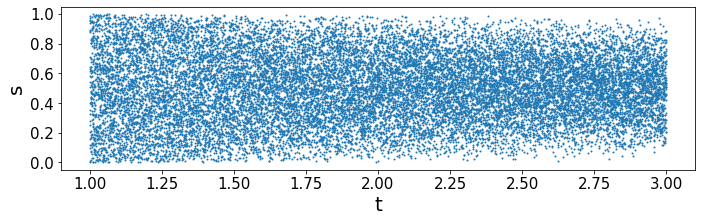

In [26]:
fig = plt.figure(figsize=(25,3))

ax = fig.add_subplot(121)

ax.plot(time_vector,ts,'.',markersize = 2)
#ax.plot(time_vector,trend,'-',linewidth = 2)
plt.xlabel('t',fontsize = 20)
plt.ylabel('s',fontsize = 20)
#plt.ylabel('$\eta_a$ [mm]',fontsize = 20)
#plt.ylim(-0.4,0.4)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#ax.text(1, 0.1, 'No Seasonality, No Linear trend', fontsize=16)

plt.show()

#fig.savefig('./figures/beta.eps',bbox_inches='tight') 

## Step (b): Regression over few quantiles 

To compute the quantile regression of few quantiles (e.g., $q = 0.05$, $q = 0.5$ and $q = 0.95$) we can use the 
Python code.

It can be seen how different quantiles change in different ways: 

- $q = 0.5$ show no clear trend; 

- $q = 0.05$ shows a positive slope; 

- $q = 0.95$ shows a negative slope.

In [14]:
y_predicted_0p95, slope_0p95 = utils.q_regression_Python(time_vector,ts,0.95)
y_predicted_0p5, slope_0p5 = utils.q_regression_Python(time_vector,ts,0.5)
y_predicted_0p05, slope_0p05 = utils.q_regression_Python(time_vector,ts,0.05)

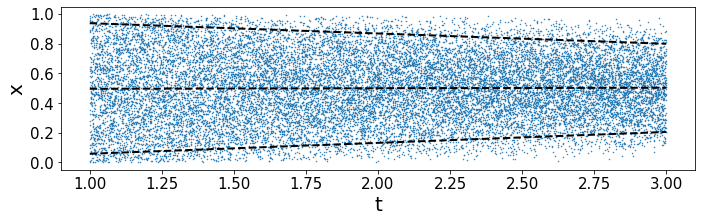

In [28]:
fig = plt.figure(figsize=(25,3))

ax = fig.add_subplot(121)

ax.plot(time_vector,ts,'.',markersize = 1)
ax.plot(time_vector,y_predicted_0p95,'--',color = 'k',linewidth = 2)
ax.plot(time_vector,y_predicted_0p5,'--',color = 'k',linewidth = 2)
ax.plot(time_vector,y_predicted_0p05,'--',color = 'k',linewidth = 2)
plt.xlabel('t',fontsize = 20)
plt.ylabel('x',fontsize = 20)
#plt.ylabel('$\eta_a$ [mm]',fontsize = 20)
#plt.ylim(-0,1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#ax.text(1, 0.1, 'No Seasonality, No Linear trend', fontsize=16)

plt.show()

#fig.savefig('./figures/explaining/time_series_plus_trend.png',bbox_inches='tight') 

## Step (c): Identify changes in moments and their significance

We estimate changes in many quantiles and project onto Hermite polynomials.

Specifically:

- We compute 19 quantile regressions, from q = 0.05 to q = 0.95 every 0.05.

- We then bootstrap (reshuffle with replacement) the time series and recompute.

- We compute this second step n times. In this case n = 1000

The bootstrap distribution should estimate the null distribution under the null assumption of stationarity. This distribution is then used to estimate the statistical significance of the results at significance level $\alpha$.

In [21]:
import time

start = time.time()

# quantiles considered
#qs = np.concatenate(([0.01],np.arange(0.05, 1.00, 0.05),[0.99]))
qs = np.arange(0.05, 1.00, 0.05)
print('Quantiles considered')
print(qs)

xt = time_vector
xt = xt - xt[0]
yt = ts
n = 1000
block_length = 1 # iid by construction
alpha = 0.05

coeffs, sigs, C, slopes = utils.changes_in_moments(xt,yt,block_length,n,qs,alpha)

end = time.time()

print('Finished in '+str(round(end - start, 2))+' seconds')

Quantiles considered
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Finished in 96.11 seconds


In [29]:
print('Coefficients')
print('Slopes from mean: '+str(coeffs[0]))
print('Slopes from variance: '+str(coeffs[1]))
print('Slopes from skewness: '+str(coeffs[2]))
print('Slopes from kurtosis: '+str(coeffs[3]))

print('')
print('Significance')
print('Slopes from mean; significant?: '+str(sigs[0]))
print('Slopes from variance; significant?: '+str(sigs[1]))
print('Slopes from skewness; significant?: '+str(sigs[2]))
print('Slopes from kurtosis; significant?: '+str(sigs[3]))

Coefficients
Slopes from mean: 0.0029223667086438303
Slopes from variance: -0.07731034275197989
Slopes from skewness: -0.004049938059831865
Slopes from kurtosis: 0.32749275822374946

Significance
Slopes from mean; significant?: False
Slopes from variance; significant?: True
Slopes from skewness; significant?: False
Slopes from kurtosis; significant?: True


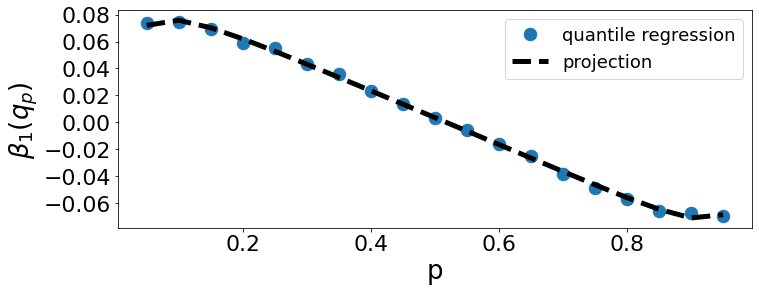

In [37]:
fig = plt.figure(figsize=(25,4))

ax = fig.add_subplot(121)

qs = np.arange(0.05, 1.00, 0.05)
ax.plot(qs,slopes,".",markersize = 25,label = 'quantile regression')
ax.plot(qs,np.transpose(utils.basis_functions(qs))@coeffs,"--k",linewidth = 5,label = 'projection')
#plt.title('(b.2)',loc = 'left',fontsize = 22)
plt.xlabel('p',fontsize = 26)
plt.ylabel(r'$\beta_{1}(q_{p})$',fontsize = 26)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.legend(loc = 'upper right',fontsize = 18)

plt.show()

#fig.savefig('./figures/projection.eps',bbox_inches='tight') 

### A look at the bootstrapped distribution

The bootstrapped distribution estimate the null distribution under the null hypothesis of stationarity. Here it is clear that changes in both variance and kurtosis are significant.

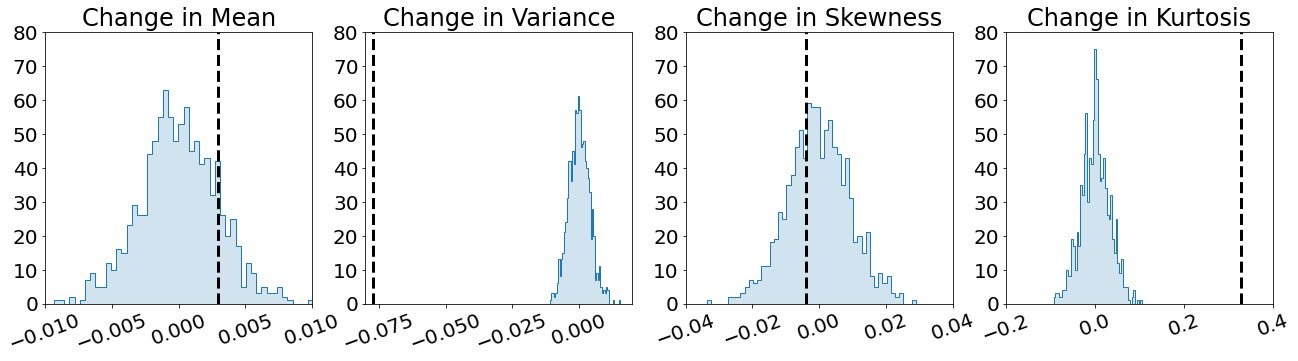

In [36]:
fig = plt.figure(figsize=(22,5))

alpha_a = 0.2
alpha_b = 1
bns = 50

def plot_title(moment): 
    if moment == 0:
        title = 'Change in Mean'
    elif moment == 1:
        title = 'Change in Variance'
    elif moment == 2:
        title = 'Change in Skewness'
    elif moment == 3:
        title = 'Change in Kurtosis'
    return title    

ax = fig.add_subplot(141)

moment = 0
title = plot_title(moment)

n, bins, patches = plt.hist(x=C[:,moment], bins= bns, color='tab:blue',
                            alpha=alpha_a, rwidth=1, log = False)
n, bins, patches = plt.hist(x=C[:,moment], bins= bns,alpha = alpha_b,color='tab:blue', histtype = 'step',linewidth = 1,rwidth=1,log = False,label = 'bootstrapped slopes')
plt.axvline(coeffs[moment],label = 'slope '+r'$\frac{d\mu_i}{dt}$',color='k',linestyle = '--',linewidth = 3)
#plt.legend(loc = 'upper left',fontsize = 21)
plt.title(title,fontsize = 24)
#plt.title('(c.1)',loc = 'left',fontsize = 20)
#plt.xlabel('slope',fontsize = fontsize_axis_label)
#plt.ylabel('$\eta_a$',fontsize = 20)
#plt.ylim(-0.4,0.4)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim([0,80])
plt.xlim([-0.01,0.01])
#plt.locator_params(axis = 'x', nbins = 5)
ax.tick_params(axis="x", labelsize=20, labelrotation=20)

ax = fig.add_subplot(142)

moment = 1
title = plot_title(moment)
    
n, bins, patches = plt.hist(x=C[:,moment], bins= bns, color='tab:blue',
                            alpha=alpha_a, rwidth=1, log = False)
n, bins, patches = plt.hist(x=C[:,moment], bins= bns,alpha = alpha_b,color='tab:blue', histtype = 'step',linewidth = 1,rwidth=1,log = False,label = 'bootstrapped slopes')
plt.axvline(coeffs[moment],label = 'slope',color='k',linestyle = '--',linewidth = 3)
#plt.legend(loc = 'upper left',fontsize = 18)
plt.title(title,fontsize = 24)
#plt.title('(c.2)',loc = 'left',fontsize = 20)
#plt.xlabel('slope',fontsize = fontsize_axis_label)
#plt.ylabel('$\eta_a$',fontsize = 20)
#plt.ylim(-0.4,0.4)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim([0,80])
plt.xlim([-0.08,0.02])
#plt.locator_params(axis = 'x', nbins = 5)
ax.tick_params(axis="x", labelsize=20, labelrotation=20)

ax = fig.add_subplot(143)

moment = 2
title = plot_title(moment)
    
n, bins, patches = plt.hist(x=C[:,moment], bins= bns, color='tab:blue',
                            alpha=alpha_a, rwidth=1, log = False)
n, bins, patches = plt.hist(x=C[:,moment], bins= bns,alpha = alpha_b,color='tab:blue', histtype = 'step',linewidth = 1,rwidth=1,log = False,label = 'bootstrapped slopes')
plt.axvline(coeffs[moment],label = 'slope',color='k',linestyle = '--',linewidth = 3)
#plt.legend(loc = 'upper left',fontsize = 18)
plt.title(title,fontsize = 24)
#plt.title('(c.2)',loc = 'left',fontsize = 20)
#plt.xlabel('slope',fontsize = fontsize_axis_label)
#plt.ylabel('$\eta_a$',fontsize = 20)
#plt.ylim(-0.4,0.4)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim([0,80])
plt.xlim([-0.04,0.04])
#plt.locator_params(axis = 'x', nbins = 5)
ax.tick_params(axis="x", labelsize=20, labelrotation=20)

ax = fig.add_subplot(144)
    
moment = 3
title = plot_title(moment)
    
n, bins, patches = plt.hist(x=C[:,moment], bins= bns, color='tab:blue',
                            alpha=alpha_a, rwidth=1, log = False)
n, bins, patches = plt.hist(x=C[:,moment], bins= bns,alpha = alpha_b,color='tab:blue', histtype = 'step',linewidth = 1,rwidth=1,log = False,label = 'bootstrapped slopes')
plt.axvline(coeffs[moment],label = 'slope',color='k',linestyle = '--',linewidth = 3)
#plt.legend(loc = 'upper left',fontsize = 18)
plt.title(title,fontsize = 24)
#plt.title('(c.2)',loc = 'left',fontsize = 20)
#plt.xlabel('slope',fontsize = fontsize_axis_label)
#plt.ylabel('$\eta_a$',fontsize = 20)
#plt.ylim(-0.4,0.4)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim([0,80])
plt.xlim([-0.2,0.4])
#plt.locator_params(axis = 'x', nbins = 5)
ax.tick_params(axis="x", labelsize=20, labelrotation=20)

plt.show()

#fig.savefig('./figures/bootstrap.eps',bbox_inches='tight') 

## Polynomials used

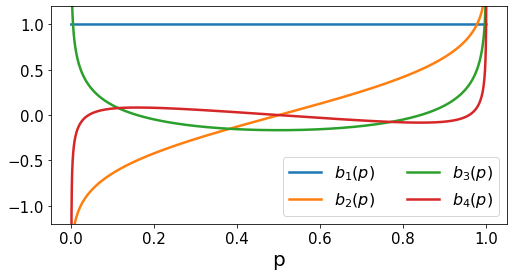

In [39]:
qs = np.arange(0.000001, 1.00, 0.000001)
basis = utils.basis_functions(qs)

fig = plt.figure(figsize=(18,4))

ax = fig.add_subplot(121)

qs = np.arange(0.000001, 1.00, 0.000001)
#ax.plot(qs,slopes,".",markersize = 25,label = 'quantile regression')
ax.plot(qs,np.transpose(utils.basis_functions(qs)[0]),"-",linewidth = 2.5,label = '$b_{1}(p)$')
ax.plot(qs,np.transpose(utils.basis_functions(qs)[1]),"-",linewidth = 2.5,label = '$b_{2}(p)$')
ax.plot(qs,np.transpose(utils.basis_functions(qs)[2]),"-",linewidth = 2.5,label = '$b_{3}(p)$')
ax.plot(qs,np.transpose(utils.basis_functions(qs)[3]),"-",linewidth = 2.5,label = '$b_{4}(p)$')

plt.xlabel('p',fontsize = 20)
#plt.ylabel(r'$\beta_{1}(q_{p})$',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='lower right',ncol=2,fontsize = 16)
#plt.legend(loc = 'lower right',fontsize = 11.6)
plt.ylim([-1.2,1.2])

plt.show()

#fig.savefig('./figures/polynomials_only.eps',bbox_inches='tight') 
#fig.savefig('./figures/explaining/time_series_plus_trend.png',bbox_inches='tight')